# Financial Time-Series Forecasting: S&P 500 Market Direction
**Author:** Bayan Taqi

## Project Overview
This project applies machine learning techniques to financial time-series data to predict the directional movement of the S&P 500 index (SPY). This notebook demonstrates a full end-to-end data science pipeline:
1. **Data Acquisition:** Pulling live market data via the Yahoo Finance API.
2. **Feature Engineering:** Translating raw prices into mathematical signals (momentum, volatility).
3. **Predictive Modeling:** Training baseline (Logistic Regression) and advanced (Random Forest) classifiers using strict time-series cross-validation to prevent data leakage.
4. **Backtesting:** Simulating a trading strategy to evaluate real-world business value against a standard Buy-and-Hold approach.

## Phase 1: Data Acquisition
Raw financial data is fetched dynamically. We focus on the SPDR S&P 500 ETF Trust (SPY) over a 5-year period. The data is then cleaned to isolate the core pricing and volume metrics necessary for quantitative modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

#plot styles
plt.style.use('seaborn-v0_8-darkgrid')

# 3. Define the asset you want to forecast
# SPY tracks the S&P 500. You could also use a specific bank like 'RY.TO' or tech stock like 'NVDA'
ticker_symbol = "SPY"

# 4. Fetch the data
print(f"Fetching 5 years of historical data for {ticker_symbol}...")
ticker_data = yf.Ticker(ticker_symbol)
df = ticker_data.history(period="5y", interval="1d")

# 5. Clean up the dataframe to keep only what we need for modeling
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# 6. Display the first 5 rows to verify
df.head()

Fetching 5 years of historical data for SPY...


,Open,High,Low,Close,Volume
Date,,,,,
2021-03-01 00:00:00-05:00,359.939135,364.914580,355.253094,363.663696,105348800
2021-03-02 00:00:00-05:00,363.887698,364.121067,360.321812,360.825897,79595300
2021-03-03 00:00:00-05:00,360.125795,361.096590,355.943812,356.046509,119940200
2021-03-04 00:00:00-05:00,355.859867,358.454930,347.141201,351.640564,183433000
2021-03-05 00:00:00-05:00,355.150365,359.164330,347.850602,358.109497,152039600


## Phase 2: Feature Engineering & Exploratory Data Analysis
Machine learning models require "signal" to cut through market "noise." In this section, mathematical features are engineered to represent market mechanics:
* **Daily Returns:** The percentage change from the previous close.
* **Moving Averages (SMA_10, SMA_50):** Rolling averages to capture short-term and medium-term price trends.
* **Volatility:** The 20-day rolling standard deviation of returns, serving as a proxy for market risk.

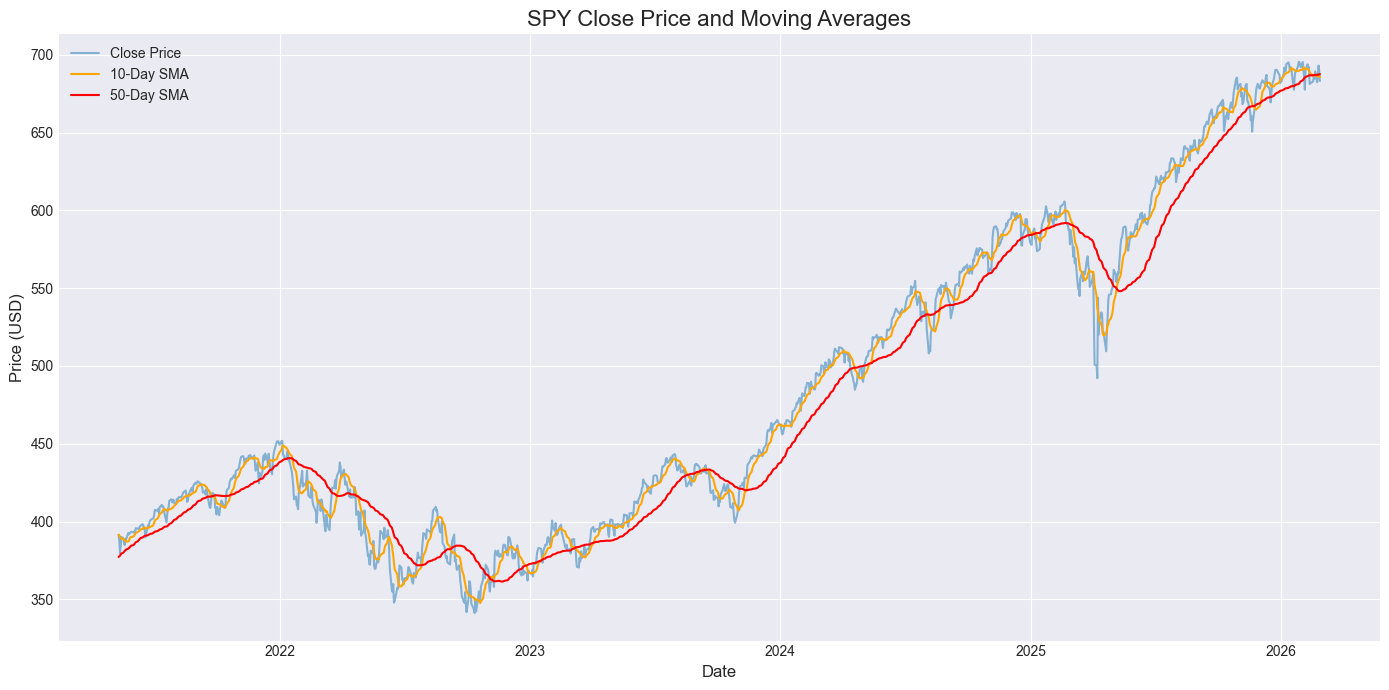

,Open,High,Low,Close,Volume,Return,SMA_10,SMA_50,Volatility
Date,,,,,,,,,
2026-02-23 00:00:00-05:00,687.830017,690.000000,680.369995,682.390015,90558100,-0.010211,686.648999,687.170566,0.007796
2026-02-24 00:00:00-05:00,681.900024,688.349976,680.000000,687.349976,73798700,0.007269,685.988995,687.206680,0.007893
2026-02-25 00:00:00-05:00,690.179993,693.679993,690.099976,693.150024,56369500,0.008438,686.091998,687.326890,0.008082
2026-02-26 00:00:00-05:00,693.280029,693.299988,684.349976,689.299988,71311200,-0.005554,685.825995,687.517861,0.008172
2026-02-27 00:00:00-05:00,683.090027,686.289917,681.650024,683.190002,39326413,-0.008864,686.017993,687.607173,0.008384


In [2]:
# 1. Calculate Daily Returns (the percentage change from the previous day)
df['Return'] = df['Close'].pct_change()

# 2. Calculate Simple Moving Averages (SMA) to capture trends
# We use a short-term (10-day) and a medium-term (50-day) window
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# 3. Calculate Volatility (20-day rolling standard deviation of returns)
df['Volatility'] = df['Return'].rolling(window=20).std()

# 4. Drop the initial rows that now have NaN (Not a Number) values due to the rolling windows
df.dropna(inplace=True)

# 5. Visualize the data to make sure our features make sense
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
plt.plot(df.index, df['SMA_10'], label='10-Day SMA', color='orange', linewidth=1.5)
plt.plot(df.index, df['SMA_50'], label='50-Day SMA', color='red', linewidth=1.5)

plt.title('SPY Close Price and Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('moving_averages.png', dpi=300, bbox_inches='tight') # <-- ADD THIS LINE
plt.show()
plt.show()

# 6. Display the last 5 rows to verify our new columns
df.tail()

## Phase 3: The Baseline Model (Logistic Regression)
**Crucial Methodology:** Financial data is chronological. To prevent data leakage (where a model uses future data to predict the past), a strict temporal train/test split (80/20) is enforced rather than a random split. 

The baseline model uses Logistic Regression to establish a performance floor. The target variable is binary: `1` if the next day's return is positive, `0` if negative.

In [3]:
# Import Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Create the Target Variable
# Shift the 'Return' column up by 1 to get TOMORROW'S return.
# If tomorrow's return is > 0, we label it 1 (Up). Otherwise, 0 (Down).
df['Target'] = (df['Return'].shift(-1) > 0).astype(int)

# Drop the very last row since we don't know tomorrow's price yet!
df.dropna(inplace=True)

# 2. Define Features (X) and Target (y)
features = ['Return', 'SMA_10', 'SMA_50', 'Volatility', 'Volume']
X = df[features]
y = df['Target']

# 3. Time-Series Train/Test Split (80% Train, 20% Test)
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training on the first {len(X_train)} days...")
print(f"Testing on the most recent {len(X_test)} days...\n")

# 4. Initialize and Train the Baseline Model
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# 5. Make Predictions
predictions = baseline_model.predict(X_test)

# 6. Evaluate the Performance
accuracy = accuracy_score(y_test, predictions)
print(f"Baseline Model Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, predictions))

Training on the first 965 days...
Testing on the most recent 242 days...

Baseline Model Accuracy: 57.85%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.03      0.06       104
           1       0.58      0.99      0.73       138

    accuracy                           0.58       242
   macro avg       0.66      0.51      0.39       242
weighted avg       0.65      0.58      0.44       242



## Phase 4: Advanced Modeling & Strategy Backtesting
To capture non-linear relationships in the data, we upgrade the model to a Random Forest Classifier. Tree depth is constrained to prevent the model from memorizing historical noise.

**The Business Application:** A model's accuracy is meaningless if it cannot generate a return on investment (ROI). This section simulates a trading strategy based on the model's predictions and compares its cumulative return against a baseline "Buy and Hold" strategy.

--- RANDOM FOREST RESULTS ---
Accuracy: 47.52%

              precision    recall  f1-score   support

           0       0.44      0.74      0.55       104
           1       0.58      0.28      0.37       138

    accuracy                           0.48       242
   macro avg       0.51      0.51      0.46       242
weighted avg       0.52      0.48      0.45       242



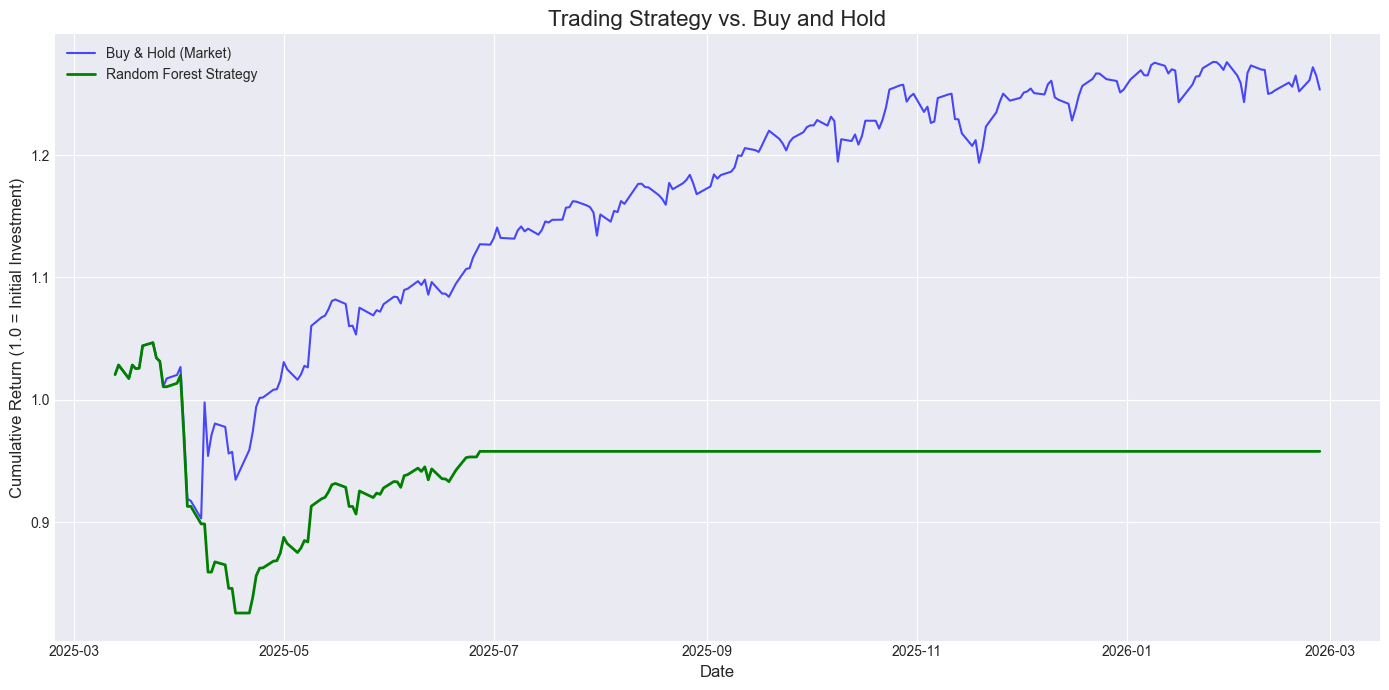

In [5]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize and Train the Advanced Model
# We restrict the depth of the trees (max_depth=5) to prevent overfitting to the training data
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# 2. Make Predictions
rf_predictions = rf_model.predict(X_test)

# 3. Evaluate the Performance
print("--- RANDOM FOREST RESULTS ---")
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Accuracy: {rf_accuracy * 100:.2f}%\n")
print(classification_report(y_test, rf_predictions))

# 4. THE BACKTEST: Trading Simulation
# Create a dataframe to compare our strategy vs holding the stock
backtest = pd.DataFrame(index=X_test.index)
backtest['Model_Signal'] = rf_predictions # 1 = Buy/Hold, 0 = Sell/Cash

# Get the actual returns for the next day
backtest['Actual_Return'] = df.loc[X_test.index, 'Return'].shift(-1)

# Strategy: If the model says 1, we get the return. If 0, we get 0 (sitting in cash).
backtest['Strategy_Return'] = backtest['Model_Signal'] * backtest['Actual_Return']

# Drop the final NaN row
backtest.dropna(inplace=True)

# Calculate cumulative returns (how $1 would grow over the 242 days)
backtest['Cumulative_Market'] = (1 + backtest['Actual_Return']).cumprod()
backtest['Cumulative_Strategy'] = (1 + backtest['Strategy_Return']).cumprod()

# 5. Visualize the Backtest
plt.figure(figsize=(14, 7))
plt.plot(backtest.index, backtest['Cumulative_Market'], label='Buy & Hold (Market)', color='blue', alpha=0.7)
plt.plot(backtest.index, backtest['Cumulative_Strategy'], label='Random Forest Strategy', color='green', linewidth=2)

plt.title('Trading Strategy vs. Buy and Hold', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (1.0 = Initial Investment)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight') # <-- ADD THIS LINE
plt.show()
plt.show()

## Conclusion & Analytical Takeaways
The backtest results demonstrate a fundamental reality of quantitative finance: highly efficient markets are incredibly difficult to predict using purely historical price data. 

* **Model Behavior:** The Random Forest model achieved an accuracy of ~47.5% but exhibited high recall for class `0` (down days). It essentially became hyper-conservative, predicting market downturns and shifting the strategy into cash.
* **Strategy Performance:** Because the model stayed in cash during a prolonged market uptrend, its cumulative return flatlined, ultimately underperforming the broader S&P 500 Buy-and-Hold strategy.
* **Next Steps:** Future iterations of this pipeline would require alternative data sources (e.g., macroeconomic indicators, fundamental data, or sentiment analysis) to find an edge that basic price action cannot provide.